<a href="https://colab.research.google.com/github/Lucia1009/TFG-Red-neuronal-turbinas-eolicas/blob/desarrollo/predicci%C3%B3n_potencias_individuales_con_regresi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Prueba de los modelos sobre las potencias de cada turbina

In [ ]:
!pip install darts -q
!pip install dash -q
!pip install --upgrade tensorflow -q
!pip install --upgrade tensorflow tensorflow_decision_forests -q
!pip install wurlitzer -q
!pip install scikeras -q
!pip install keras-tuner -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import R2Score

import tensorflow_decision_forests as tfdf
import ydf
import keras_tuner as kt
from wurlitzer import sys_pipes
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go

from google.colab import drive

# Obtención de datos del archivo

In [ ]:
drive.mount('/content/drive')

df=pd.read_csv('/content/drive/MyDrive/TFG/elvalle_reparto_saltos_sp75.csv', delimiter=";",decimal=".",skiprows = [1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_filtrado=df[(df['TIME'] % 600==540)]
print(df_filtrado.shape)
print(df.shape)

# for col in df_filtrado:
#     print("\n",col, "\n", df_filtrado[col].unique())

(21600, 150)
(216000, 150)


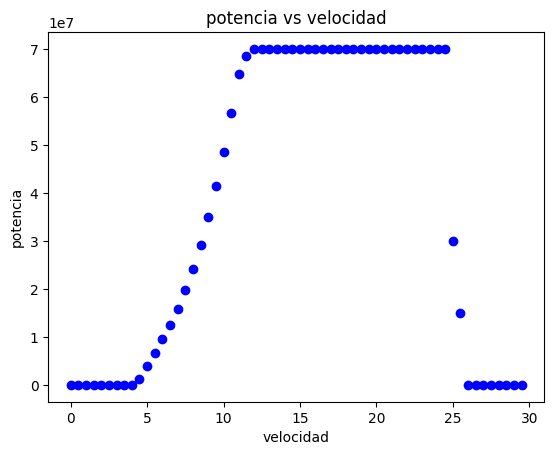

360


In [ ]:
# unique_wd, counts = np.unique(df_filtrado['wd'], return_counts=True)
# print(counts, "\n", unique_wd )

direcciones={}
for i in range(0,360):
    # Separo los datos para cada dirección
    filtered_data = df_filtrado[(df_filtrado['wd'] <= i) & (df_filtrado['wd'] > (i - 1 ))]

    # Selecciono solo las columnas que me interesan
    selected_columns = filtered_data[['ws', 'WF_Power', 'wd']]

    direcciones[i]=selected_columns
    # print(i, direcciones[i])

plt.title("potencia vs velocidad")
plt.scatter(direcciones[1]['ws'], direcciones[1]['WF_Power'], color="blue")

plt.xlabel("velocidad")
plt.ylabel("potencia")
plt.show()
print(len(direcciones))

In [ ]:
datos = pd.DataFrame(df_filtrado[['wd', 'ws', 'WF_Power']])

datos['sin_wd'] = np.sin(datos['wd']*np.pi/180)
datos['cos_wd'] = np.cos(datos['wd']*np.pi/180)
datos = datos.drop('wd', axis=1)


datos.tail()

,ws,WF_Power,sin_wd,cos_wd
215959,27.500000,1.157064e-41,-0.017452,0.999848
215969,28.000000,-1.711043e-52,-0.017452,0.999848
215979,28.500000,6.197535e-59,-0.017452,0.999848
215989,29.000000,7.481889e-71,-0.017452,0.999848
215999,29.500001,-1.019971e-84,-0.017452,0.999848


## Obtención de datos para el modelo

*Creación de los conjuntos de train y test*

In [ ]:
##### Obtención de datos ####

columns_datos = ['wd']
columns_potencias = []

for j in range(1, 15):
    # Selecciono solo las columnas que me interesan
    columns_potencias.append('TC' + str(j) + '.T.Pg.signal[1]')
    if j < 10:
        columns_datos.append('v[0' + str(j) + ']')
    else:
        columns_datos.append('v[' + str(j) + ']')

datos_x_turb = df_filtrado[columns_datos].copy()
datos_x_turb['sin_wd'] = np.sin(datos_x_turb['wd'] * np.pi / 180)
datos_x_turb['cos_wd'] = np.cos(datos_x_turb['wd'] * np.pi / 180)
datos_x_turb = datos_x_turb.drop('wd', axis=1)

datos_y_turb = df_filtrado[columns_potencias].copy()

columns_datos.remove('wd')
columns_datos.append('sin_wd')
columns_datos.append('cos_wd')

#### OBTENCIÓN DE DATOS ESTRATIFICADOS ####

X_test_turb = []
y_test_turb = []
X_train_turb = []
y_train_turb = []
for i in range(datos.shape[0]):

  if i%4==0:
      X_test_turb.append(datos_x_turb.iloc[i])
      y_test_turb.append(datos_y_turb.iloc[i])
  else:
      X_train_turb.append(datos_x_turb.iloc[i])
      y_train_turb.append(datos_y_turb.iloc[i])


X_test_p_turb = pd.DataFrame(X_test_turb)
y_test_p_turb = pd.DataFrame(y_test_turb)
X_train_p_turb = pd.DataFrame(X_train_turb)
y_train_p_turb = pd.DataFrame(y_train_turb)

## Regresión

In [ ]:
# ALEATORIOS # Separar datos de entrenamiento y prueba
# X_train_p_turb, X_test_p_turb, y_train_p_turb, y_test_p_turb = train_test_split(datos_x_turb, datos_y_turb, test_size=0.2)

# Transformación de datos
transformador = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=3))])
X_train_p_transf_turb = transformador.fit_transform(X_train_p_turb)
X_test_p_transf_turb = transformador.transform(X_test_p_turb)

# Modelo de red neuronal
def build_model(input_shape, output_shape):
    model_nn_turb = keras.Sequential([
        keras.layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(output_shape)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model_nn_turb.compile(loss='mse', optimizer=optimizer, metrics=['R2Score','mae', 'mse'])
    return model_nn_turb

model_nn_turb = build_model(X_train_p_transf_turb.shape[1], len(columns_potencias))
model_nn_turb.fit(X_train_p_transf_turb, y_train_p_turb, epochs=40, verbose=1)
model_nn_turb.evaluate(X_test_p_transf_turb, y_test_p_turb)

Epoch 1/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - R2Score: -1.4967 - loss: 13100341264384.0000 - mae: 2815077.5000 - mse: 13100341264384.0000
Epoch 2/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - R2Score: -1.4189 - loss: 12734327422976.0000 - mae: 2940929.7500 - mse: 12734327422976.0000
Epoch 3/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - R2Score: -1.3490 - loss: 12382125424640.0000 - mae: 2941471.5000 - mse: 12382125424640.0000
Epoch 4/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - R2Score: -1.3265 - loss: 12248988778496.0000 - mae: 2970766.7500 - mse: 12248988778496.0000
Epoch 5/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: -1.3055 - loss: 12106533437440.0000 - mae: 2973697.0000 - mse: 12106533437440.0000
Epoch 6/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: -1.2268 - loss: 11721571827712.0000 - mae: 2945719.5000 - mse: 11721571827712.0000
Epoch 7/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: -1.1169 - loss: 11161838813184.0000 - mae: 2870790.2500 - mse

[262445744128.0, 0.9503341317176819, 334164.125, 262445744128.0]

In [16]:
#### GRAFICA REGRESIÓN ####

app = dash.Dash(__name__)

app.layout = html.Div([

    html.Div([
        "Ángulo de viento: ",
        dcc.Input(id='angulo', value=0, type='number')
    ]),
    html.Div([
        "Numero de la turbina: ",
        dcc.Input(id='turbina', value=1, type='number')
    ]),
    dcc.Graph(id='graph')
])

@app.callback(
    Output('graph', 'figure'),
    Input('angulo', 'value'),
    Input('turbina', 'value'))
def update_output_div(angulo, turbina):
    sin_angulo_val = np.sin(angulo * np.pi / 180)
    cos_angulo_val = np.cos(angulo * np.pi / 180)

    # Seleccionar velocidad y potencia en función del número de turbina
    if turbina < 10:
        velocidad = f'v[0{turbina}]'
    else:
        velocidad = f'v[{turbina}]'

    potencia = f'TC{turbina}.T.Pg.signal[1]'

    # Filtrar todos los datos con base en el ángulo
    datos_filtrados_x = datos_x_turb[(datos_x_turb['sin_wd'] == sin_angulo_val) &
                            (datos_x_turb['cos_wd'] == cos_angulo_val)]

    datos_filtrados_y = datos_y_turb[(datos_x_turb['sin_wd'] == sin_angulo_val) &
                            (datos_x_turb['cos_wd'] == cos_angulo_val)]

    datos_filtrados_test = X_test_p_turb[(X_test_p_turb['sin_wd'] == sin_angulo_val) &
                                          (X_test_p_turb['cos_wd'] == cos_angulo_val)]

    y_test_filtrado = y_test_p_turb[(X_test_p_turb['sin_wd'] == sin_angulo_val) &
                                    (X_test_p_turb['cos_wd'] == cos_angulo_val)][potencia]

    if not datos_filtrados_test.empty:
        # Crear la gráfica
        fig = go.Figure()

        # Agregar puntos de potencia real (test)
        fig.add_trace(go.Scatter(x=datos_filtrados_test[velocidad], y=y_test_filtrado,
                                  mode='markers', name='Potencia real (test)',
                                  marker=dict(color='blue')))

        # Añadir línea de datos reales (entrenamiento) en azul
        fig.add_trace(go.Scatter(x=datos_filtrados_x[velocidad], y=datos_filtrados_y[potencia],
                                mode='lines', name='Línea real',
                                line=dict(color='blue')))


        # Predecir los valores de test
        datos_x_test_transf = transformador.transform(datos_filtrados_test)
        datos_y_test_pred = model_nn_turb.predict(datos_x_test_transf)

        potencia_index = columns_potencias.index(potencia)

        # Use the index to access the predicted values for that column
        fig.add_trace(go.Scatter(x=datos_filtrados_test[velocidad], y=datos_y_test_pred[:, potencia_index],
                                  mode='markers', name='Potencia predicha (test)',
                                  marker=dict(color='red')))


        # Predicciones en el rango completo de velocidad
        rango_x_graf = datos_filtrados_x[columns_datos]


        # Transformar y predecir en el rango de velocidades
        rango_df_transf_graf = transformador.transform(rango_x_graf)
        rango_y_pred_graf = model_nn_turb.predict(rango_df_transf_graf)

        # Añadir línea de predicción continua
        fig.add_trace(go.Scatter(x=rango_x_graf[velocidad], y=rango_y_pred_graf[:,potencia_index],
                            mode='lines', name='Línea predicción',
                            line=dict(color='red')))


        fig.update_layout(
            title="Potencia vs. Velocidad",
            xaxis_title=f"Velocidad del viento ({velocidad})",
            yaxis_title=f"Potencia ({potencia})"
        )

    return fig




if __name__ == '__main__':
    app.run_server(debug=True, port=8054)


<IPython.core.display.Javascript object>

## Random forest

In [ ]:
##### Variables usadas ####

# X_test_p_turb
# y_test_p_turb
# X_train_p_turb
# y_train_p_turb


In [ ]:
#### SCIKIT RANDOM FOREST ####

regr = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=0, verbose=1)
regr.fit(X_train_p_turb, y_train_p_turb)
regr.score(X_test_p_turb, y_test_p_turb)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   39.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


0.9937362637281548

In [15]:
#### GRAFICA REGRESIÓN ####

app = dash.Dash(__name__)

app.layout = html.Div([

    html.Div([
        "Ángulo de viento: ",
        dcc.Input(id='angulo', value=0, type='number')
    ]),
    html.Div([
        "Numero de la turbina: ",
        dcc.Input(id='turbina', value=1, type='number')
    ]),
    dcc.Graph(id='graph')
])

@app.callback(
    Output('graph', 'figure'),
    Input('angulo', 'value'),
    Input('turbina', 'value'))
def update_output_div(angulo, turbina):
    sin_angulo_val = np.sin(angulo * np.pi / 180)
    cos_angulo_val = np.cos(angulo * np.pi / 180)

    # Seleccionar velocidad y potencia en función del número de turbina
    if turbina < 10:
        velocidad = f'v[0{turbina}]'
    else:
        velocidad = f'v[{turbina}]'

    potencia = f'TC{turbina}.T.Pg.signal[1]'

    # Filtrar todos los datos con base en el ángulo
    datos_filtrados_x = datos_x_turb[(datos_x_turb['sin_wd'] == sin_angulo_val) &
                            (datos_x_turb['cos_wd'] == cos_angulo_val)]

    datos_filtrados_y = datos_y_turb[(datos_x_turb['sin_wd'] == sin_angulo_val) &
                            (datos_x_turb['cos_wd'] == cos_angulo_val)]

    datos_filtrados_test = X_test_p_turb[(X_test_p_turb['sin_wd'] == sin_angulo_val) &
                                          (X_test_p_turb['cos_wd'] == cos_angulo_val)]

    y_test_filtrado = y_test_p_turb[(X_test_p_turb['sin_wd'] == sin_angulo_val) &
                                    (X_test_p_turb['cos_wd'] == cos_angulo_val)][potencia]

    if not datos_filtrados_test.empty:
        # Crear la gráfica
        fig = go.Figure()

        # Agregar puntos de potencia real (test)
        fig.add_trace(go.Scatter(x=datos_filtrados_test[velocidad], y=y_test_filtrado,
                                  mode='markers', name='Potencia real (test)',
                                  marker=dict(color='blue')))

        # Añadir línea de datos reales (entrenamiento) en azul
        fig.add_trace(go.Scatter(x=datos_filtrados_x[velocidad], y=datos_filtrados_y[potencia],
                                mode='lines', name='Línea real',
                                line=dict(color='blue')))


        # Predecir los valores de test

        datos_y_test_pred = regr.predict(datos_filtrados_test)

        potencia_index = columns_potencias.index(potencia)

        # Use the index to access the predicted values for that column
        fig.add_trace(go.Scatter(x=datos_filtrados_test[velocidad], y=datos_y_test_pred[:, potencia_index],
                                  mode='markers', name='Potencia predicha (test)',
                                  marker=dict(color='red')))


        # Predicciones en el rango completo de velocidad
        rango_x_graf = datos_filtrados_x[columns_datos]

        # Transformar y predecir en el rango de velocidades

        rango_y_pred_graf = regr.predict(rango_x_graf)

        # Añadir línea de predicción continua
        fig.add_trace(go.Scatter(x=rango_x_graf[velocidad], y=rango_y_pred_graf[:,potencia_index],
                            mode='lines', name='Línea predicción',
                            line=dict(color='red')))


        fig.update_layout(
            title="Potencia vs. Velocidad",
            xaxis_title=f"Velocidad del viento ({velocidad})",
            yaxis_title=f"Potencia ({potencia})"
        )

    return fig




if __name__ == '__main__':
    app.run_server(debug=True, port=8055)


<IPython.core.display.Javascript object>